<a href="https://colab.research.google.com/github/Rafikul10/Cat-vs-Dog-CNN-Classifier/blob/main/Cat_vs_Dog_CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cat vs Dog CNN-Classifier


[![Python 3.7.15](https://img.shields.io/badge/Python-3.7.15-brightgreen)](https://www.python.org/downloads/release/python-3715/) [![TensorFlow 2.9.2](https://img.shields.io/badge/TensorFlow-2.9.2-orange)](https://www.gitclear.com/open_repos/tensorflow/tensorflow/release/v2.9.2) [![problem Vision](https://img.shields.io/badge/Problem-Vision-blue)]() [![Data kaggle](https://img.shields.io/badge/Data-Kaggle-blueviolet)](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset)



###Introduction
This example shows how to do image classification from scratch, without leveraging pre-trained weights or a pre-made Keras Application model. Dataset si taken from the [kaggle](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset) Cats vs Dogs binary classification dataset.


I use the `image_dataset_from_directory` utility to generate the datasets, and Keras image preprocessing layers for image standardization and data augmentation.

### Dependencies

* Google Colab
* Tensorflow 2.9.2
* Python 3.7.15
* Matplotlib
* Scikit-Learn
* Pandas
* Numpy
* Keras

Install dependencies using [conda](https://docs.conda.io/en/latest/)

###TODO -

*    Pick the dataset from [kaggle](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset)
*    Download the dataset using `curl` and unzip fo the dataset
*    **Filter** out corupted images
*    Generate a **Train**, **Test** datset
*    Visualize the data
*    Data **Agumentation**
*    **Standardizing** the data
*    Build a **Model**
*    Train the **Model**
*    Test the **Model** in new data

###Setup

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Raw data download

In [18]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  62.1M      0  0:00:12  0:00:12 --:--:-- 76.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   101M      0  0:00:07  0:00:07 --:--:--  113M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!ls PetImages

Cat  Dog


###Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


###Generate a dataset
Split the data into 80% and 20% to Train and Test set by using `image_dataset_from_directory` 

In [6]:
image_size = (224, 224)                 # Define image size 224x224 
batch_size = 32                         # define batch size to 32

# Train set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Test set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [7]:
from glob import glob
cat =glob('/content/PetImages/Cat/*') 
dog = glob('/content/PetImages/Dog/*')
total_img = len(cat) + len(dog)
total_img

23412

In [8]:
len(cat)

11742

In [9]:
25002-12501

12501

###Visualize the data
Here are the random 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

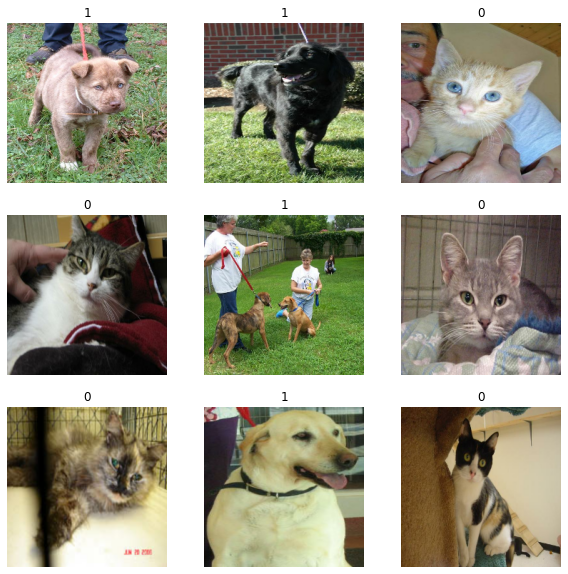

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis('off')

###Using image data augmentation
This cat and dog dataset is small so, i'm artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as
* Random horizontal
* Random zoom
* Horizontal flips

This helps expose the model to different aspects of the training data while slowing down overfitting.

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    ]
    )

Let's visualize what the augmented samples look like, by applying `data_augmentation` repeatedly to the random image in the dataset:

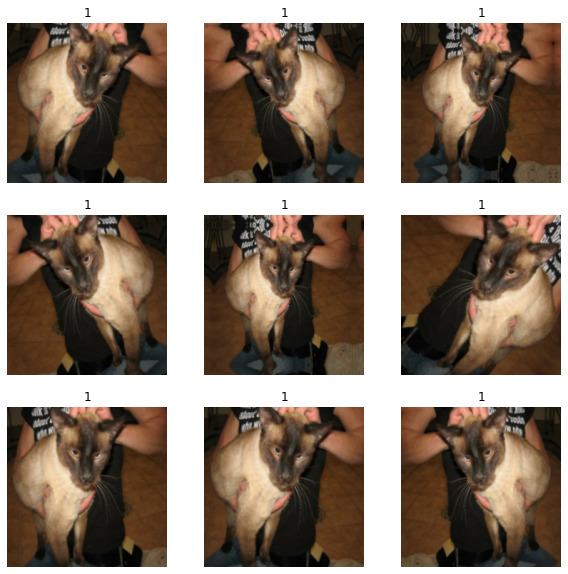

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        new_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(new_images[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(int(labels[0]))

###Configure the dataset for performance
Let's make sure to use buffered prefetching so i can yield data from disk without having I/O becoming blocking:

In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

###Model Build
I'll build a small network for this dataset.

Note that:

* I start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
* I include a Dropout layer before the final classification layer. 
* I used batch normalization layers which applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

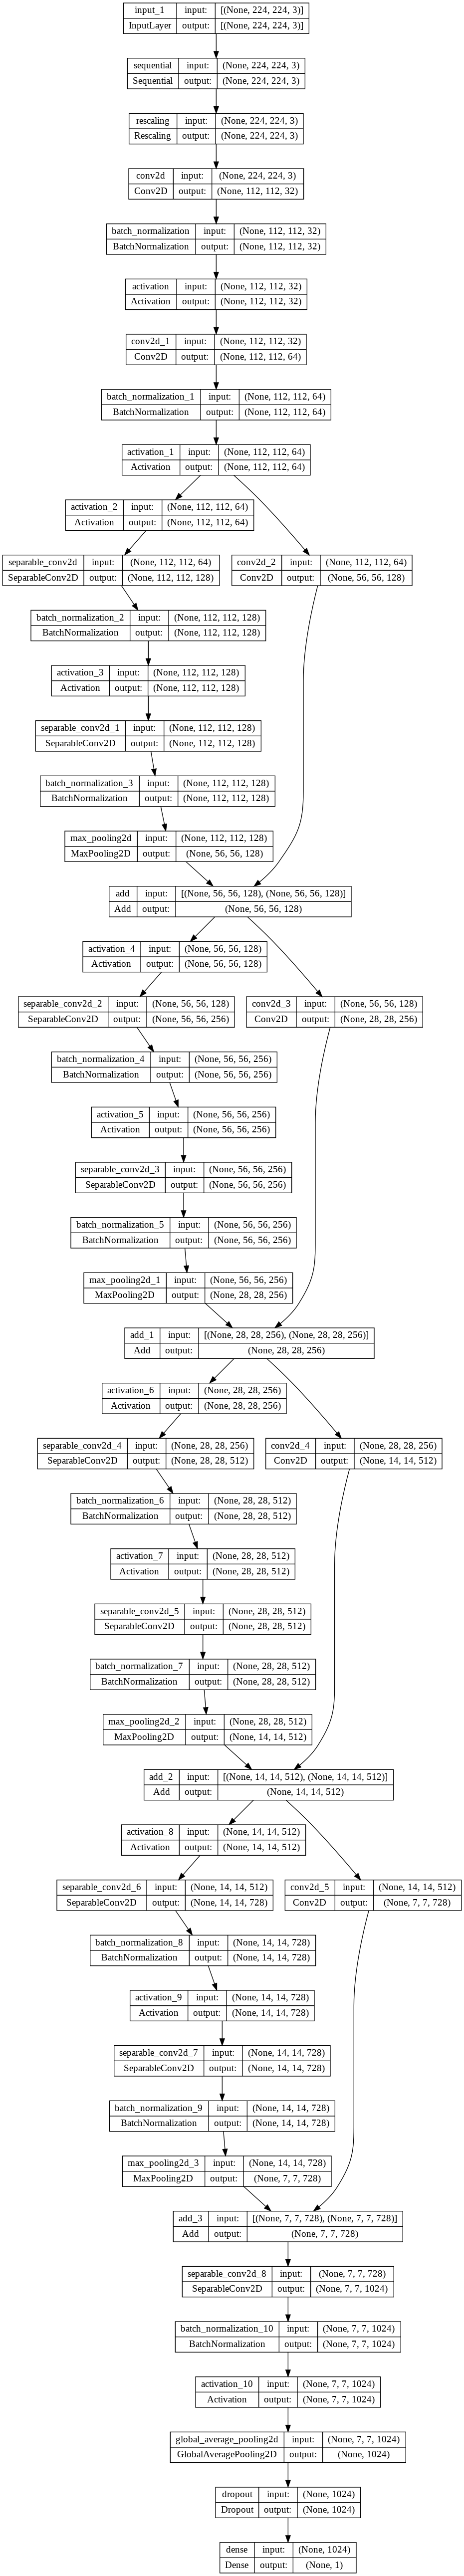

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)  # Rescale the image pixel values of the image will be between 0 and 1 
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)  # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

###Train the model

In [15]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 8077s 14s/step - loss: 0.6183 - accuracy: 0.6696 - val_loss: 1.0039 - val_accuracy: 0.5179
Epoch 2/5
586/586 [==============================] - 8093s 14s/step - loss: 0.4715 - accuracy: 0.7786 - val_loss: 0.6115 - val_accuracy: 0.7181
Epoch 3/5
586/586 [==============================] - 8158s 14s/step - loss: 0.3963 - accuracy: 0.8280 - val_loss: 0.2920 - val_accuracy: 0.8780
Epoch 4/5
586/586 [==============================] - 8198s 14s/step - loss: 0.3186 - accuracy: 0.8616 - val_loss: 0.2481 - val_accuracy: 0.9020
Epoch 5/5
586/586 [==============================] - 8136s 14s/step - loss: 0.2644 - accuracy: 0.8875 - val_loss: 0.4054 - val_accuracy: 0.8257


###Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [16]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 1s 1s/step
This image is 99.20 percent cat and 0.80 percent dog.


In [ ]:
# Save it as a h5 file
from keras.models import load_model

model.save('cat&dog_cnn_model.h5')